# Naive Bayes Training — Breast Cancer Wisconsin (Diagnostic)

This notebook:
- Loads data from `data/processed`
- Trains **Gaussian Naive Bayes**.
- Evaluates on a held-out test split.
- Saves the trained model and metadata to `models/`.


In [1]:
import os, json
from pathlib import Path
import numpy as np
import pandas as pd
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
import matplotlib.pyplot as plt

%matplotlib inline


Matplotlib is building the font cache; this may take a moment.


In [ ]:

PROJECT_ROOT = Path.cwd()
DATA_ROOT = PROJECT_ROOT / "data"
PROCESSED = DATA_ROOT / "processed"
RAW = DATA_ROOT / "raw"
MODELS_DIR = PROJECT_ROOT / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_ROOT:", DATA_ROOT)
print("Processed exists?:", PROCESSED.exists())


PROJECT_ROOT: C:\Users\Rhea Maria\Desktop\Year 2\GitHub Year 2\DMML
DATA_ROOT: C:\Users\Rhea Maria\Desktop\Year 2\GitHub Year 2\DMML\data
Processed exists?: True


In [3]:
def load_processed():
    X_train_p = PROCESSED / "X_train_scaled.csv"
    X_test_p  = PROCESSED / "X_test_scaled.csv"
    y_train_p = PROCESSED / "y_train.csv"
    y_test_p  = PROCESSED / "y_test.csv"
    feat_p    = PROCESSED / "feature_names.txt"

    if all(p.exists() for p in [X_train_p, X_test_p, y_train_p, y_test_p]):
        X_train = pd.read_csv(X_train_p)
        X_test  = pd.read_csv(X_test_p)
        y_train = pd.read_csv(y_train_p).squeeze()
        y_test  = pd.read_csv(y_test_p).squeeze()
        feature_names = list(X_train.columns)
        if feat_p.exists():
            feature_names = [ln.strip() for ln in open(feat_p, 'r', encoding='utf-8').read().splitlines() if ln.strip()]
        print("Loaded processed data from", PROCESSED)
        return X_train, X_test, y_train, y_test, feature_names
    return None, None, None, None, None

X_train, X_test, y_train, y_test, feature_names = load_processed()


Loaded processed data from C:\Users\Rhea Maria\Desktop\Year 2\GitHub Year 2\DMML\data\processed


In [4]:
if X_train is None:
    RAW_FILE = None
    for name in ["wdbc.data", "wdbc.csv"]:
        cand = RAW / name
        if cand.exists():
            RAW_FILE = cand
            break

    if RAW_FILE is None:
        raise FileNotFoundError(
            "Processed data not found and RAW file missing. "
            "Expected processed under data/processed or raw UCI file at data/raw/wdbc.data(.csv)."
        )

    print("Preprocessing from raw:", RAW_FILE)
    df = pd.read_csv(RAW_FILE, header=None)
    df.columns = [
        "ID","Diagnosis",
        "radius_mean","texture_mean","perimeter_mean","area_mean","smoothness_mean","compactness_mean",
        "concavity_mean","concave_points_mean","symmetry_mean","fractal_dimension_mean",
        "radius_se","texture_se","perimeter_se","area_se","smoothness_se","compactness_se",
        "concavity_se","concave_points_se","symmetry_se","fractal_dimension_se",
        "radius_worst","texture_worst","perimeter_worst","area_worst","smoothness_worst","compactness_worst",
        "concavity_worst","concave_points_worst","symmetry_worst","fractal_dimension_worst"
    ]
    df["Diagnosis"] = df["Diagnosis"].map({"M":1,"B":0})
    df = df.drop(columns=["ID"])

    feature_names = [c for c in df.columns if c != "Diagnosis"]
    X = df[feature_names].copy()
    y = df["Diagnosis"].copy()

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    scaler = StandardScaler()
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=feature_names)
    X_test  = pd.DataFrame(scaler.transform(X_test), columns=feature_names)


In [5]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_test)
try:
    y_proba = gnb.predict_proba(X_test)[:, 1]
except Exception:
    y_proba = None


In [6]:
metrics = {
    "accuracy": float(accuracy_score(y_test, y_pred)),
    "precision": float(precision_score(y_test, y_pred)),
    "recall": float(recall_score(y_test, y_pred)),
    "f1": float(f1_score(y_test, y_pred)),
}
if y_proba is not None:
    try:
        metrics["roc_auc"] = float(roc_auc_score(y_test, y_proba))
    except Exception:
        pass

print(json.dumps(metrics, indent=2))
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))


{
  "accuracy": 0.9210526315789473,
  "precision": 0.9230769230769231,
  "recall": 0.8571428571428571,
  "f1": 0.8888888888888888,
  "roc_auc": 0.9890873015873015
}

Classification report:
               precision    recall  f1-score   support

           0     0.9200    0.9583    0.9388        72
           1     0.9231    0.8571    0.8889        42

    accuracy                         0.9211       114
   macro avg     0.9215    0.9077    0.9138       114
weighted avg     0.9211    0.9211    0.9204       114



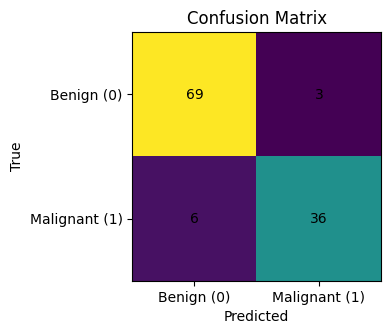

In [7]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation='nearest')
plt.title('Confusion Matrix')
plt.xticks([0,1], ['Benign (0)','Malignant (1)'])
plt.yticks([0,1], ['Benign (0)','Malignant (1)'])
for (i, j), z in np.ndenumerate(cm):
    plt.text(j, i, str(z), ha='center', va='center')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


In [8]:
import joblib, platform, sklearn

model_path = MODELS_DIR / "naive_bayes_breast_cancer_model.pkl"
meta_path  = MODELS_DIR / "naive_bayes_model_metadata.json"

joblib.dump(gnb, model_path)

metadata = {
    "model_type": "GaussianNB",
    "saved_at": datetime.utcnow().isoformat() + "Z",
    "metrics": metrics,
    "feature_names": feature_names if feature_names is not None else list(X_train.columns),
    "paths": {
        "model": str(model_path),
        "data_root": str(DATA_ROOT),
        "processed_dir": str(PROCESSED),
    },
    "env": {
        "python": platform.python_version(),
        "sklearn": sklearn.__version__,
    }
}

with open(meta_path, "w", encoding="utf-8") as f:
    json.dump(metadata, f, indent=2)

print("Saved:", model_path)
print("Saved:", meta_path)


Saved: C:\Users\Rhea Maria\Desktop\Year 2\GitHub Year 2\DMML\models\naive_bayes_breast_cancer_model.pkl
Saved: C:\Users\Rhea Maria\Desktop\Year 2\GitHub Year 2\DMML\models\naive_bayes_model_metadata.json


C:\Users\Rhea Maria\AppData\Local\Temp\ipykernel_19572\2210627928.py:10: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "saved_at": datetime.utcnow().isoformat() + "Z",
